In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random
import numpy as np 

def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 
import numpy as np 
from scipy.sparse import dok_matrix
import scipy as sp
from scipy import signal
def compute_Reliability(spike_matrix,t,t_R):
    '''
    Computes the value of Reliability, a synchrony measurement that computes the variance of a convoluted spike train that is the sum of the spike trains of each neuron.

    Parameters:
        spike_matrix (tuple[tuple[int,int]] | sparse_matrix):
            matrix containing spike trains, each row contains a diffent neuron.
        t (list[float]):
            time array, time points of the simulation
        t_R (float):
            Time constant

    Returns:
        reliability / reliability_max (float):
            The computed value of reliability, normalised so (theorically) is between 0 and 1.
        Convolved_matrix (tuple[float]):
            The convolved spike train.
    '''

    #compute the time step of the simulation
    T = t[-1] - t[0]
    dt = T / len(t)

    #we need to work with a np.ndarray for the convolution, if it is a sparse_matrix, change it to that type
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    #Compute the mean number of spikes
    num_spikes = (spike_matrix>0).sum()/num_neurons

    #Compute the kernel, and convolve the sum spike train with it
    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = 1/ t_R *np.exp(-t / t_R)
    Convolved_matrix = signal.convolve(joined_matrix,kernel)[0:len(spike_matrix[0,:])]
    #Convolved_matrix = joined_matrix

    #compute the measurements of reliability
    reliability = 1 / t[len(t) - 1] * np.trapz(np.square(Convolved_matrix), dx = dt) - np.square( 1 / t[len(t) - 1] * np.trapz(Convolved_matrix,dx =dt))
    reliability_max = ( num_neurons**2 * num_spikes / ( t_R * 2 * T ) - ( num_neurons * num_spikes / T )**2 )
    #reliability_max = 1
    return reliability/reliability_max, Convolved_matrix

In [2]:
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

In [5]:
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

mean_delay = 3  # Mean conduction delay in ms

delay_distributions = np.clip(np.random.normal(mean_delay, std_delay, size=(N, N)), 0, None)  # Ensure delays are non-negative
delay_steps_matrix = np.maximum(1, (delay_distributions / dt).astype(int))  # Convert delays to time steps

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043

J = np.random.normal(0, 0.1, size=(N))

I = 0.33

Avg_Connections = 40
connection_probability = Avg_Connections / N

g = np.zeros((N, N))

for j in range(N):
    for i in range(N):
        if i != j:
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03

v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size=(N))
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

# Initialize delay buffers for s(t)
max_delay_steps = np.max(delay_steps_matrix)
delay_buffer = np.zeros((N, max_delay_steps))


def dxdt(t, x, k, a, b, I, Esyn, J, tauS, delay_buffer, delay_steps_matrix):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]

    delayed_s = np.zeros(N)
    for j in range(N):
        delays = delay_steps_matrix[j, :]
        delayed_s[j] = np.dot(g[j, :], delay_buffer[np.arange(N), -delays])  # Apply delayed activation

    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * delayed_s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS

    return np.concatenate([dvdt, dudt, dsdt, dpdt])


def v_spike(t, x, k, a, b, I, Esyn, J, tauS, delay_buffer, delay_steps_matrix):
    return x[:N].max() - v_thresh

v_spike.terminal = True
v_spike.direction = 1

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

In [7]:
# Firing Rate
sd_values = np.linspace(1, 14, 14)
firing_rates = []

for std_delay in sd_values:
    # Generate conduction delays for the current standard deviation
    delay_distributions = np.clip(np.random.normal(mean_delay, std_delay, size=(N, N)), 0, None)
    delay_steps_matrix = np.maximum(1, (delay_distributions / dt).astype(int))
    max_delay_steps = np.max(delay_steps_matrix)
    delay_buffer = np.zeros((N, max_delay_steps))

    # Initial conditions
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)

    t0 = 0
    y0 = np.concatenate([v_init, u_init, s_init, p_init])
    spike_times = np.zeros((50000, 2))
    spikeCounter = 0

    def dxdt(t, x):
        v = x[:N]
        u = x[N:2*N]
        s = x[2*N:3*N]
        p = x[3*N:4*N]
        
        delayed_s = np.zeros(N)
        for j in range(N):
            delays = delay_steps_matrix[j, :]
            delayed_s[j] = np.dot(g[j, :], delay_buffer[np.arange(N), -delays])
        
        dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * delayed_s
        dudt = k * a * (b * v - u)
        dsdt = -s / tauS + p / tauS
        dpdt = -p / tauS

        return np.concatenate([dvdt, dudt, dsdt, dpdt])

    while t0 < T:
        sol = solve_ivp(dxdt, [t0, T], y0, rtol=1e-8)
        t0 = sol.t[-1]
        y = sol.y[:, -1]

        v_init = y[:N]
        u_init = y[N:2*N]
        s_init = y[2*N:3*N]
        p_init = y[3*N:4*N]

        if np.any(v_init > v_thresh):
            spikes = np.where(v_init > v_thresh)[0]
            for spike in spikes:
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += 2.718

        delay_buffer = np.roll(delay_buffer, shift=-1, axis=1)
        delay_buffer[:, -1] = s_init

        y0 = np.concatenate([v_init, u_init, s_init, p_init])

    # Calculate firing rate
    valid_spikes = spike_times[:spikeCounter]
    firing_rate = len(valid_spikes[valid_spikes[:, 0] > 100]) / (N * (T - 100)) * 1000
    firing_rates.append(firing_rate)
    print(f"SD: {std_delay:.2f}, Firing Rate: {firing_rate:.2f} Hz")

# Plotting
plt.figure()
plt.plot(sd_values, firing_rates, marker='o')
plt.xlabel("Standard Deviation of Delay (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.title("Firing Rate vs. SD of Conduction Delay")
plt.grid()
plt.show()

KeyboardInterrupt: 

SD: 1.00, Firing Rate: 9.08 Hz
SD: 2.00, Firing Rate: 8.58 Hz
SD: 3.00, Firing Rate: 8.80 Hz
SD: 4.00, Firing Rate: 9.38 Hz
SD: 5.00, Firing Rate: 9.33 Hz
SD: 6.00, Firing Rate: 9.45 Hz
SD: 7.00, Firing Rate: 2.80 Hz
SD: 8.00, Firing Rate: 3.15 Hz
SD: 9.00, Firing Rate: 9.37 Hz
SD: 10.00, Firing Rate: 8.80 Hz
SD: 11.00, Firing Rate: 0.00 Hz
SD: 12.00, Firing Rate: 11.57 Hz
SD: 13.00, Firing Rate: 4.92 Hz
SD: 14.00, Firing Rate: 0.00 Hz


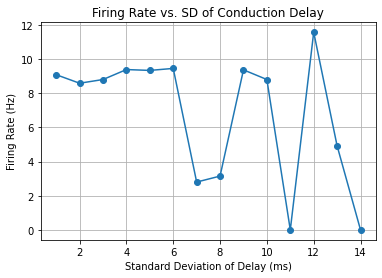

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters for the simulation
np.random.seed(101)
N = 300
T = 300
dt = 0.005
mean_delay = 3

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30
Esyn = -70
tauS = 3.043043043043043

J = np.random.normal(0, 0.1, size=(N))
I = 0.33

Avg_Connections = 40
connection_probability = Avg_Connections / N

g = np.zeros((N, N))
for j in range(N):
    for i in range(N):
        if i != j and np.random.rand() < connection_probability:
            g[j, i] = 0.03

# Loop through SD values
sd_values = np.linspace(1, 14, 14)
firing_rates = []

for std_delay in sd_values:
    # Generate conduction delays for the current standard deviation
    delay_distributions = np.clip(np.random.normal(mean_delay, std_delay, size=(N, N)), 0, None)
    delay_steps_matrix = np.maximum(1, (delay_distributions / dt).astype(int))
    max_delay_steps = np.max(delay_steps_matrix)
    delay_buffer = np.zeros((N, max_delay_steps))

    # Initial conditions
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)

    t0 = 0
    y0 = np.concatenate([v_init, u_init, s_init, p_init])
    spike_times = np.zeros((50000, 2))
    spikeCounter = 0

    def dxdt(t, x):
        v = x[:N]
        u = x[N:2*N]
        s = x[2*N:3*N]
        p = x[3*N:4*N]
        
        delayed_s = np.zeros(N)
        for j in range(N):
            delays = delay_steps_matrix[j, :]
            delayed_s[j] = np.dot(g[j, :], delay_buffer[np.arange(N), -delays])
        
        dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * delayed_s
        dudt = k * a * (b * v - u)
        dsdt = -s / tauS + p / tauS
        dpdt = -p / tauS

        return np.concatenate([dvdt, dudt, dsdt, dpdt])

    while t0 < T:
        sol = solve_ivp(dxdt, [t0, T], y0, rtol=1e-8)
        t0 = sol.t[-1]
        y = sol.y[:, -1]

        v_init = y[:N]
        u_init = y[N:2*N]
        s_init = y[2*N:3*N]
        p_init = y[3*N:4*N]

        if np.any(v_init > v_thresh):
            spikes = np.where(v_init > v_thresh)[0]
            for spike in spikes:
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += 2.718

        delay_buffer = np.roll(delay_buffer, shift=-1, axis=1)
        delay_buffer[:, -1] = s_init

        y0 = np.concatenate([v_init, u_init, s_init, p_init])

    # Calculate firing rate
    valid_spikes = spike_times[:spikeCounter]
    firing_rate = len(valid_spikes[valid_spikes[:, 0] > 100]) / (N * (T - 100)) * 1000
    firing_rates.append(firing_rate)
    print(f"SD: {std_delay:.2f}, Firing Rate: {firing_rate:.2f} Hz")

# Plotting
plt.figure()
plt.plot(sd_values, firing_rates, marker='o')
plt.xlabel("Standard Deviation of Delay (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.title("Firing Rate vs. SD of Conduction Delay")
plt.grid()
plt.show()


In [ ]:
# % Neurons that spike
sd_values = np.linspace(0, 14, 15)
no_neurons_spike = []


for std_delay in sd_values:
    # Generate conduction delays for the current standard deviation
    delay_distributions = np.clip(np.random.normal(mean_delay, std_delay, size=(N, N)), 0, None)
    delay_steps_matrix = np.maximum(1, (delay_distributions / dt).astype(int))
    max_delay_steps = np.max(delay_steps_matrix)
    delay_buffer = np.zeros((N, max_delay_steps))

    # Initial conditions
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)

    t0 = 0
    y0 = np.concatenate([v_init, u_init, s_init, p_init])
    spike_times = np.zeros((50000, 2))
    spikeCounter = 0

    def dxdt(t, x):
        v = x[:N]
        u = x[N:2*N]
        s = x[2*N:3*N]
        p = x[3*N:4*N]
        
        delayed_s = np.zeros(N)
        for j in range(N):
            delays = delay_steps_matrix[j, :]
            delayed_s[j] = np.dot(g[j, :], delay_buffer[np.arange(N), -delays])
        
        dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * delayed_s
        dudt = k * a * (b * v - u)
        dsdt = -s / tauS + p / tauS
        dpdt = -p / tauS

        return np.concatenate([dvdt, dudt, dsdt, dpdt])

    while t0 < T:
        sol = solve_ivp(dxdt, [t0, T], y0, rtol=1e-8)
        t0 = sol.t[-1]
        y = sol.y[:, -1]

        v_init = y[:N]
        u_init = y[N:2*N]
        s_init = y[2*N:3*N]
        p_init = y[3*N:4*N]

        if np.any(v_init > v_thresh):
            spikes = np.where(v_init > v_thresh)[0]
            for spike in spikes:
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += 2.718

        delay_buffer = np.roll(delay_buffer, shift=-1, axis=1)
        delay_buffer[:, -1] = s_init

        y0 = np.concatenate([v_init, u_init, s_init, p_init])
    
    # Determine the number of unique neurons that spiked
    spiking_neurons = len(set([neuron for _, neuron in spike_times]))
    no_neurons_spike.append(spiking_neurons)
    print(f"SD: {std_delay:.2f}, Number of Neurons that Spiked: {spiking_neurons}")

no_neurons_spike_array = np.array(no_neurons_spike)
fractional_spike = no_neurons_spike_array/N
plt.figure()
plt.plot(sd_values, fractional_spike, marker='o', linestyle='-')
plt.xlabel('Standard Deviation on Conduction Delay (ms)')
plt.ylabel('% Neurons that Spiked')
plt.title('Standard Deviation on Consuction Delay (ms) vs % that Spiked')
plt.grid(True)
plt.show()